# Extended Kalman Filter (EKF) Demo

Demonstrates EKF with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)
- User-provided Jacobian functions

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ekf import ExtendedKalmanFilter
import utils

tf.random.set_seed(42)
np.random.seed(42)

2025-11-19 08:36:44.788061: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Generate Data

In [2]:
# Create model and generate trajectory using utils
dt = 1.0
model = utils.create_model(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 100
true_states, obs = utils.generate_trajectory(model, T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 100 observations
True states: (4, 101), Observations: (2, 100)


## 2. Define Functions and Jacobians

In [3]:
# Get filter functions from utils
state_transition_fn = utils.create_state_transition_fn(model)
observation_fn = utils.create_observation_fn()
state_transition_jacobian_fn = utils.create_state_jacobian_fn(model)
observation_jacobian_fn = utils.create_observation_jacobian_fn(model)

print("Functions and Jacobians defined")

Functions and Jacobians defined


## 3. Initialize and Run EKF

In [4]:
# Initialize EKF
x0 = true_states[:,1]
Sigma0 = tf.eye(4, dtype=tf.float32) * 100.0

ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model.Q, 
    R=model.R, 
    x0=x0, 
    Sigma0=Sigma0,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

In [5]:
# Run filter
filtered_states, predicted_states = ekf.filter(obs)
print(f"Filtered states: {filtered_states.shape}")

Filtered states: (4, 101)


## 4. Evaluate Performance

In [6]:
# Compute performance metrics
pos_error_filtered = utils.compute_position_error(filtered_states, true_states, exclude_first=True)
pos_error_predicted = utils.compute_position_error(
    tf.concat([true_states[:, 0:1], predicted_states], axis=1), 
    true_states, 
    exclude_first=True
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))
rmse_predicted = tf.sqrt(tf.reduce_mean(pos_error_predicted**2))

print("\nPerformance (Position RMSE):")
print(f"  Predicted: {rmse_predicted.numpy():.2f}")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")
print(f"  Improvement: {(1 - rmse_filtered/rmse_predicted)*100:.1f}%")


Performance (Position RMSE):
  Predicted: 13.82
  Filtered:  13.28
  Improvement: 3.9%


## 5. Visualize Results

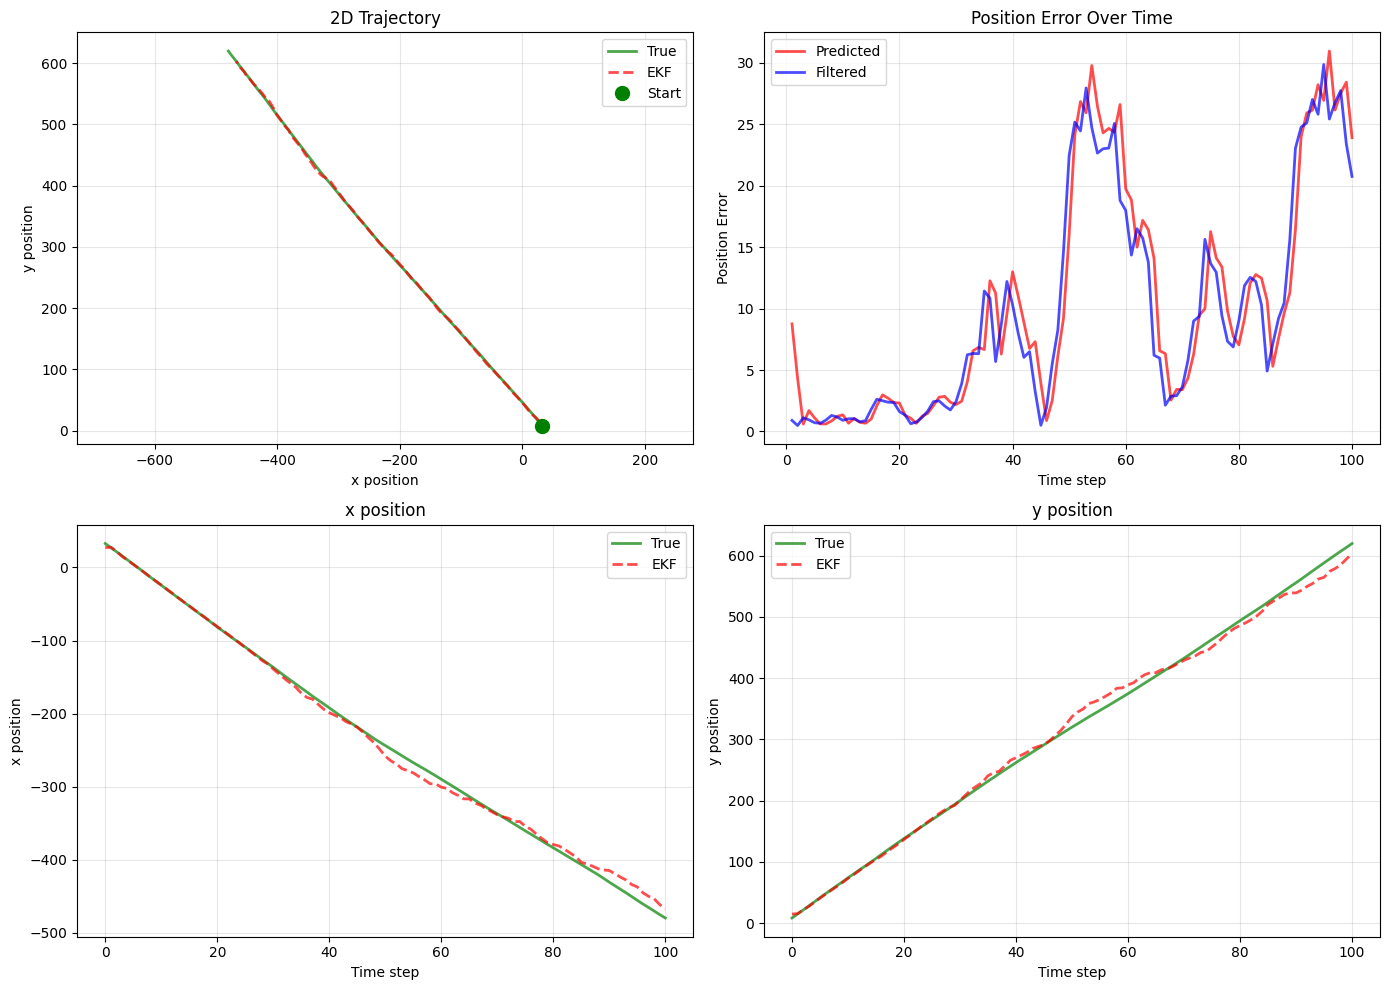

In [7]:
# Plot full comparison using utils
true_np = true_states.numpy()
filtered_np = filtered_states.numpy()

filtered_dict = {'EKF': filtered_np}
error_dict = {
    'Predicted': pos_error_predicted.numpy(),
    'Filtered': pos_error_filtered.numpy()
}

fig = utils.plot_full_comparison(true_np, filtered_dict, error_dict)
plt.show()

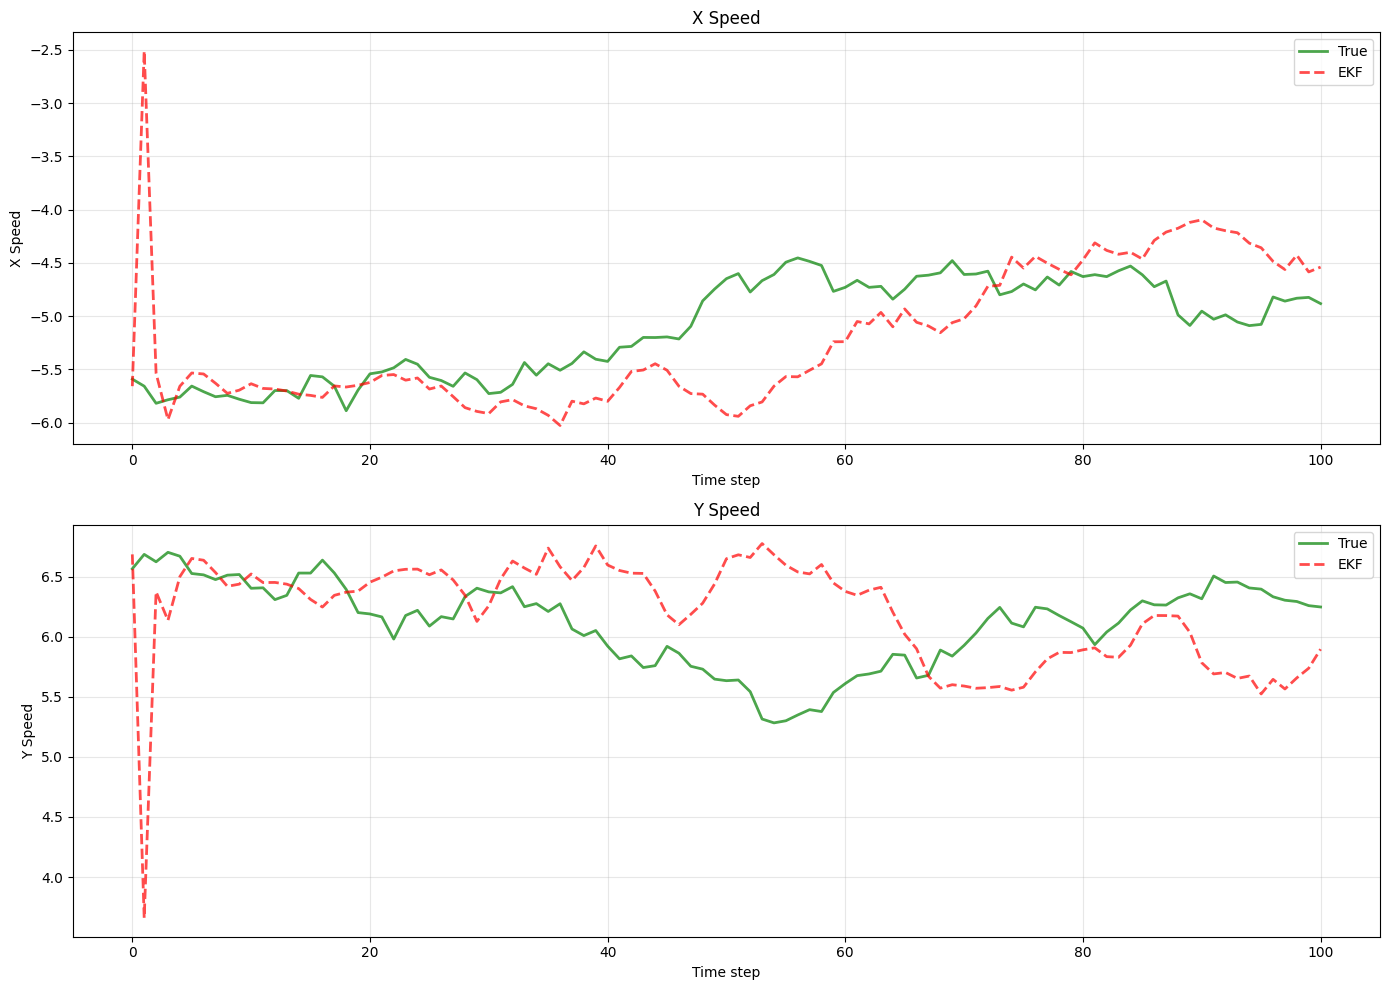

In [8]:
# Plot velocity comparison using utils
fig = utils.plot_velocity_comparison(true_np, filtered_dict)
plt.show()